## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import make_regression, make_classification, load_digits
from sklearn.model_selection import train_test_split
from copy import deepcopy

from sparse_model import *
from train import train_one_model, valid_model
from pruning import evaluate_sensitivity, do_pruning
from speed_metrics import *


SEED = 8642
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cpu')  
# mps_deivce = torch.device('mps')
device

device(type='cpu')

In [2]:
layer_sizes = {
    'small': [1000, 100, 10, 1], 
    'base': [1000, 1000, 100, 1],
    'large': [1000, 10000, 1000, 1]
}

metric_table = {
    'basic': [],
    'SensitivityBased': [],
    'L1': []
}

## Data

In [3]:
def get_regression_dataloaders(layers, n_samples=1000, batch_size=32):
    X, y = make_regression(n_samples=n_samples, n_features=layers[0], 
                           n_informative=layers[0], random_state=SEED)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    train_dataset, test_dataset = train_test_split(list(zip(X, y)), test_size=0.2, random_state=SEED)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [4]:
layers = layer_sizes['small']
train_loader, val_loader = get_regression_dataloaders(layers)

## Base model

In [ ]:
layers = layer_sizes['small']
criterion = nn.MSELoss()
model = MyModel(layers).to(device)
n_init_params = get_number_of_params(model)
n_init_params

101121

Training Progress: 100%|██████████| 500/500 [00:12<00:00, 38.56it/s]


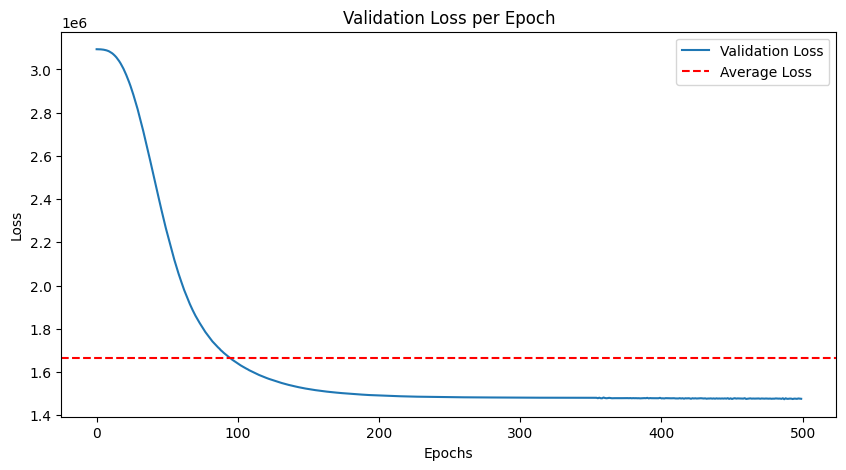

1473895.7142857143

In [ ]:
train_one_model(model, train_loader, val_loader, device, 
                epochs=500, criterion=criterion, patience=50)

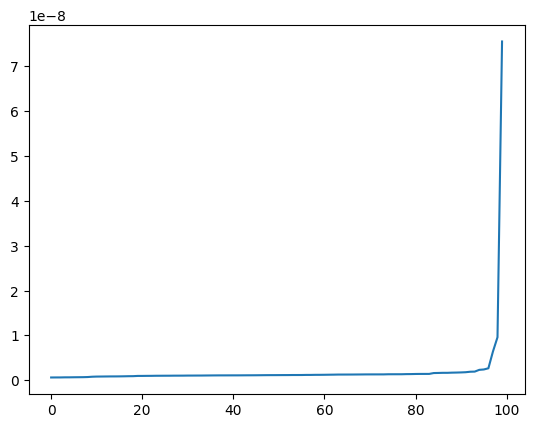

In [ ]:
itop = [inference_time_over_params(model, val_loader, device)
        for _ in range(100)]
itop = np.sort(itop)
metric_table['basic'].append(np.mean(itop))
plt.plot(itop)

In [7]:
def convert_dense_to_sparse_network(model: nn.Module) -> nn.Module:
    """
    Converts a given dense neural network model to a sparse neural network model.

    This function recursively iterate through the given model and replaces all instances of
    `nn.Linear` layers with `SparseLinear` layers

    Args:
        model (nn.Module): The dense neural network model to be converted.

    Returns:
        nn.Module: A new neural network model with sparse layers.
    """
    if isinstance(model, MyModel):
        new_model = model.__class__(model.layers)
    else: 
        new_model = model.__class__()

    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            sparse_weight = dense_to_sparse(module.weight.data)
            sparse_bias = dense_to_sparse(module.bias.data)

            setattr(new_model, name, SparseLinear(sparse_weight, sparse_bias))
        else:
            setattr(new_model, name, convert_dense_to_sparse_network(module))
    return new_model

In [9]:
sparse_model = convert_dense_to_sparse_network(model)
sparse_model

MyModel(
  (model): Sequential(
    (0): SparseLinear()
    (1): ReLU()
    (2): SparseLinear()
    (3): ReLU()
    (4): SparseLinear()
  )
)

## Experiments

In [11]:
linear = nn.Linear(100, 1)

sparse_weight = dense_to_sparse(linear.weight.data)
sparse_bias = dense_to_sparse(linear.bias.data)
just_sparse_linear = SparseLinear(sparse_weight, sparse_bias)

sparse_linear = deepcopy(just_sparse_linear)

In [12]:
sparse_putting_linear1 = SparseRecursiveLinear(sparse_linear, None)
print(sparse_putting_linear1.sparse_linear.weight_indices, "\n")
sparse_putting_linear1.replace(0, 6)
sparse_putting_linear1.replace(0, 7)
# sparse_putting_linear1.replace(0, 6)
print(sparse_putting_linear1.sparse_linear.weight_indices)
print(sparse_putting_linear1.embed_weight_indeces, "\n")

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]) 

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        

In [13]:
sparse_putting_linear2 = SparseRecursiveLinear(sparse_linear, sparse_putting_linear1)
sparse_putting_linear2.replace(0, 8)
sparse_putting_linear2.replace(0, 9)
print(sparse_putting_linear1.sparse_linear.weight_indices)
print(sparse_putting_linear2.embed_weight_indeces, "\n")

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   1,   2,   3,   4,   5,  10,  11,  12,  13,  14,  15,  16,  17,
          18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
          32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
          46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
          60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
          74,  75,  76,  77,  78

In [14]:
sparse_putting_linear3 = SparseRecursiveLinear(sparse_linear, sparse_putting_linear2, is_last=True)
sparse_putting_linear3.replace(0, 3)
print(sparse_putting_linear1.sparse_linear.weight_indices)
print(sparse_putting_linear3.embed_weight_indeces, "\n")

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   1,   2,   4,   5,  10,  11,  12,  13,  14,  15,  16,  17,  18,
          19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
          33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
          47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
          61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
          75,  76,  77,  78,  79

In [19]:
sample_input = torch.randn(1, 100)

In [21]:
putted_output = sparse_putting_linear3(sample_input)
putted_output

tensor([[0.8076]], grad_fn=<AsStridedBackward0>)